In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import shutil
import os

# Define your destination path in Google Drive
drive_output_path = '/content/drive/My Drive/NuInsSeg/ddunet'
os.makedirs(drive_output_path, exist_ok=True)

In [3]:
opts = {}
opts['number_of_channel'] = 3
opts['treshold'] = 0.5
opts['epoch_num'] = 100
opts['quick_run'] = 1
opts['batch_size'] = 16
opts['random_seed_num'] = 19
opts['k_fold'] = 2
opts['save_val_results'] = 1
opts['init_LR'] = 0.001
opts['LR_decay_factor'] = 0.5
opts['LR_drop_after_nth_epoch'] = 20
opts['crop_size'] = 512
## output directories
opts['result_save_path'] ='prediction_image/'
opts['result_save_path'] = os.path.join(drive_output_path, opts['result_save_path'])
opts['model_save_path'] ='output_model/'
opts['model_save_path'] = os.path.join(drive_output_path, opts['model_save_path'])

In [4]:
if not os.path.exists(opts['model_save_path']):
    os.makedirs(opts['model_save_path'])
if not os.path.exists(opts['result_save_path']):
    os.makedirs(opts['result_save_path'])
if not os.path.exists(os.path.join(opts['result_save_path'],'validation/unet')):
    os.makedirs(os.path.join(opts['result_save_path'],'validation/unet'))
if not os.path.exists(os.path.join(opts['result_save_path'],'validation/watershed_unet')):
    os.makedirs(os.path.join(opts['result_save_path'],'validation/watershed_unet'))

In [7]:
!pip install keras opencv-python tensorflow albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.2/105.2 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.4/70.4 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 846.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 369.4/369.4 kB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 92.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 MB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 108.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 63.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.8/502.8 kB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.

In [8]:
import os
from glob import glob
import numpy as np
from sklearn.model_selection import KFold,StratifiedKFold
import time
import cv2
import keras
from keras.callbacks import CSVLogger, LearningRateScheduler, ModelCheckpoint
from keras.layers import *
from keras.models import Model, load_model
from keras.optimizers import Adam
from albumentations import *
from keras import backend as K
from skimage.feature import peak_local_max
from scipy import ndimage as ndi
from skimage.segmentation import watershed
import skimage.morphology
from skimage.io import imsave
from skimage.morphology import remove_small_objects
import tqdm
from random import shuffle
import matplotlib.pyplot as plt
import pandas as pd
from scipy.ndimage import gaussian_filter

/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:82: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


In [9]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ipateam/nuinsseg")

print("Path to dataset files:", path)

100%|██████████| 1.52G/1.52G [00:10<00:00, 157MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ipateam/nuinsseg/versions/5


In [10]:
# base_path = 'Dataset/'
base_path = path
organ_names = [ name for name in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, name)) ]
organ_names

['mouse fat (white and brown)_subscapula',
 'human testis',
 'human tongue',
 'human pylorus',
 'human salivory gland',
 'human peritoneum',
 'mouse heart',
 'mouse muscle_tibia',
 'human cerebellum',
 'human liver',
 'human bladder',
 'human umbilical cord',
 'human kidney',
 'human lung',
 'human cardia',
 'human rectum',
 'mouse kidney',
 'human oesophagus',
 'human epiglottis',
 'human pancreas',
 'human tonsile',
 'human spleen',
 'mouse spleen',
 'human muscle',
 'mouse thymus',
 'human melanoma',
 'human placenta',
 'human brain',
 'human jejunum',
 'mouse liver',
 'mouse femur']

In [11]:
# input and outpu paths
# img_path = glob(os.path.join(base_path, '*/tissue images/', '*.png'))
# binary_mask_path = glob(os.path.join(base_path, '*/mask binary/', '*.png'))
# distance_mask_path = glob(os.path.join(base_path, '*/distance maps/', '*.png'))
# label_mask_path = glob(os.path.join(base_path, '*/label masks modify/', '*.tif'))
# vague_mask_path =  glob(os.path.join(base_path, '*/vague areas/mask binary/', '*.png'))

#Smaller Data
img_path = glob(os.path.join(base_path, 'mouse kidney/tissue images/', '*.png'))
binary_mask_path = glob(os.path.join(base_path, 'mouse kidney/mask binary/', '*.png'))
distance_mask_path = glob(os.path.join(base_path, 'mouse kidney/distance maps/', '*.png'))
label_mask_path = glob(os.path.join(base_path, '*mouse kidney/label masks modify/', '*.tif'))
vague_mask_path =  glob(os.path.join(base_path, '*mouse kidney/vague areas/mask binary/', '*.png'))


img_path.sort()
binary_mask_path.sort()
distance_mask_path.sort()
label_mask_path.sort()
vague_mask_path.sort()


# create folders to save the best models and images (if needed) for each fold
if not os.path.exists('prediction_image/'):
    os.makedirs('prediction_image/')
if not os.path.exists('output_model/'):
    os.makedirs('output_model/')
if not os.path.exists(opts['result_save_path']+ 'validation/unet'):
    os.makedirs(opts['result_save_path'] + 'validation/unet')
if not os.path.exists(opts['result_save_path']+ 'validation/watershed_unet'):
    os.makedirs(opts['result_save_path'] + 'validation/watershed_unet')

In [12]:
rand_num = np.random.randint(len(img_path))
print('image path: {}\n'.format(img_path[rand_num]),
      'binary mask path: {}\n'.format(binary_mask_path[rand_num]),
      'distance mask path: {}\n'.format(distance_mask_path[rand_num]),
      'label mask path: {}\n'.format(label_mask_path[rand_num]))

image path: /root/.cache/kagglehub/datasets/ipateam/nuinsseg/versions/5/mouse kidney/tissue images/mouse_kidney_35.png
 binary mask path: /root/.cache/kagglehub/datasets/ipateam/nuinsseg/versions/5/mouse kidney/mask binary/mouse_kidney_35.png
 distance mask path: /root/.cache/kagglehub/datasets/ipateam/nuinsseg/versions/5/mouse kidney/distance maps/mouse_kidney_35.png
 label mask path: /root/.cache/kagglehub/datasets/ipateam/nuinsseg/versions/5/mouse kidney/label masks modify/mouse_kidney_35.tif



In [13]:
# learning rate scheduler
def step_decay_schedule(initial_lr=1e-3, decay_factor=0.75, epochs_drop=1000):
    '''
    Wrapper function to create a LearningRateScheduler with step decay schedule.
    '''
    def schedule(epoch):
        return initial_lr * (decay_factor ** np.floor(epoch/epochs_drop))

    return LearningRateScheduler(schedule, verbose = 1)

In [14]:
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
#####################################################################################
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)
#####################################################################################
def bce_dice_loss(y_true, y_pred):
    return 0.5 * tf.keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)
#####################################################################################################################
def mse_score(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true), axis=-1)
#####################################################################################################################

In [15]:

def dual_decoder_unet_binary(IMG_CHANNELS, LearnRate):
    inputs = Input((None, None, IMG_CHANNELS))
    #encoder
    # s = Lambda(lambda x: x / 255)(inputs)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)


    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.1)(c5)
    c5 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    ## decoder for dis unet
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs1 = Conv2D(1, (1, 1), activation='linear', name='output_dis')(c9)


    ## decoder for segmentation unet
    u6_seg = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6_seg = concatenate([u6_seg, c4])
    c6_seg = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6_seg)
    c6_seg = Dropout(0.2)(c6_seg)
    c6_seg = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6_seg)

    u7_seg = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6_seg)
    u7_seg = concatenate([u7_seg, c3])
    c7_seg = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7_seg)
    c7_seg = Dropout(0.2)(c7_seg)
    c7_seg = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7_seg)

    u8_seg = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7_seg)
    u8_seg = concatenate([u8_seg, c2])
    c8_seg = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8_seg)
    c8_seg = Dropout(0.1)(c8_seg)
    c8_seg = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8_seg)

    u9_seg = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8_seg)
    u9_seg = concatenate([u9_seg, c1], axis=3)
    c9_seg = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9_seg)
    c9_seg = Dropout(0.1)(c9_seg)
    c9_seg = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9_seg)

    outputs2 = Conv2D(1, (1, 1), activation='sigmoid', name='output_seg')(c9_seg)

    model_dual_path = models.Model(inputs=[inputs], outputs=[outputs1, outputs2])
    model_dual_path.compile(optimizer = Adam(learning_rate=LearnRate),
                            loss={'output_dis': 'mean_squared_error', 'output_seg': bce_dice_loss},
                            loss_weights=  {'output_dis': 1.0, 'output_seg': 1.0},
                            metrics={'output_seg':dice_coef, 'output_dis':mse_score})
    # model_dual_path.summary()
    return model_dual_path

In [16]:
# Random Transformations for Data Augmentation
from albumentations import RandomCrop
def albumentation_aug(p=1.0, crop_size_row = 448, crop_size_col = 448 ):
    return Compose([
        # RandomCrop(crop_size_row, crop_size_col, p=1),
        OneOf([
            RandomCrop(crop_size_row, crop_size_col),
            NoOp()
        ], p=0.5),
        CLAHE(clip_limit=4.0, tile_grid_size=(8, 8),p=0.5),
        RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, brightness_by_max=True, p=0.4),
        HueSaturationValue(hue_shift_limit=20, sat_shift_limit=20, val_shift_limit=20, p=0.1),
        HorizontalFlip(p=0.5),
        VerticalFlip(p=0.5),
        RandomRotate90(p=0.5),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=20, interpolation=1,
                         border_mode=4, p=0.1),

    ], p=p, additional_targets={'dist_map': 'mask'})
# last  p has the second proiroty comapred to the p inside each argument
#(e.g. HorizontalFlip(always_apply=False, p=0.5) )
#############################################################################################################
# def albumentation_aug_light(p=1.0, crop_size_row = 448, crop_size_col = 448):
#     return Compose([
#         RandomCrop(crop_size_row, crop_size_col, always_apply=True, p=1.0),
#         HorizontalFlip(always_apply=False, p=0.5),
#         VerticalFlip(always_apply=False, p=0.5),
#         RandomRotate90(always_apply=False, p=0.5),
#         ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=20, interpolation=1,
#                          border_mode=4 , always_apply=False, p=0.1),
#     ], p=p, additional_targets={'mask1': 'mask','mask2': 'mask'})

In [17]:
def get_fast_aji(true, pred):
    """AJI version distributed by MoNuSeg, has no permutation problem but suffered from
    over-penalisation similar to DICE2.
    Fast computation requires instance IDs are in contiguous orderding i.e [1, 2, 3, 4]
    not [2, 3, 6, 10]. Please call `remap_label` before hand and `by_size` flag has no
    effect on the result.
    """
    true = np.copy(true)  # ? do we need this
    pred = np.copy(pred)
    true_id_list = list(np.unique(true))
    pred_id_list = list(np.unique(pred))
    #print(len(pred_id_list))
    if len(pred_id_list) == 1:
        return 0

    true_masks = [None,]
    for t in true_id_list[1:]:
        t_mask = np.array(true == t, np.uint8)
        true_masks.append(t_mask)

    pred_masks = [None,]
    for p in pred_id_list[1:]:
        p_mask = np.array(pred == p, np.uint8)
        pred_masks.append(p_mask)

    # prefill with value
    pairwise_inter = np.zeros(
        [len(true_id_list) - 1, len(pred_id_list) - 1], dtype=np.float64
    )
    pairwise_union = np.zeros(
        [len(true_id_list) - 1, len(pred_id_list) - 1], dtype=np.float64
    )

    # caching pairwise
    for true_id in true_id_list[1:]:  # 0-th is background
        t_mask = true_masks[true_id]
        pred_true_overlap = pred[t_mask > 0]
        pred_true_overlap_id = np.unique(pred_true_overlap)
        pred_true_overlap_id = list(pred_true_overlap_id)
        for pred_id in pred_true_overlap_id:
            if pred_id == 0:  # ignore
                continue  # overlaping background
            p_mask = pred_masks[pred_id]
            total = (t_mask + p_mask).sum()
            inter = (t_mask * p_mask).sum()
            pairwise_inter[true_id - 1, pred_id - 1] = inter
            pairwise_union[true_id - 1, pred_id - 1] = total - inter

    pairwise_iou = pairwise_inter / (pairwise_union + 1.0e-6)
    # pair of pred that give highest iou for each true, dont care
    # about reusing pred instance multiple times
    paired_pred = np.argmax(pairwise_iou, axis=1)
    pairwise_iou = np.max(pairwise_iou, axis=1)
    # exlude those dont have intersection
    paired_true = np.nonzero(pairwise_iou > 0.0)[0]
    paired_pred = paired_pred[paired_true]
    # print(paired_true.shape, paired_pred.shape)
    overall_inter = (pairwise_inter[paired_true, paired_pred]).sum()
    overall_union = (pairwise_union[paired_true, paired_pred]).sum()

    paired_true = list(paired_true + 1)  # index to instance ID
    paired_pred = list(paired_pred + 1)
    # add all unpaired GT and Prediction into the union
    unpaired_true = np.array(
        [idx for idx in true_id_list[1:] if idx not in paired_true]
    )
    unpaired_pred = np.array(
        [idx for idx in pred_id_list[1:] if idx not in paired_pred]
    )
    for true_id in unpaired_true:
        overall_union += true_masks[true_id].sum()
    for pred_id in unpaired_pred:
        overall_union += pred_masks[pred_id].sum()

    aji_score = overall_inter / overall_union
    #print(aji_score)
    return aji_score

from scipy.optimize import linear_sum_assignment

#############################################################################################################
def get_fast_pq(true, pred, match_iou=0.5):
    """`match_iou` is the IoU threshold level to determine the pairing between
    GT instances `p` and prediction instances `g`. `p` and `g` is a pair
    if IoU > `match_iou`. However, pair of `p` and `g` must be unique
    (1 prediction instance to 1 GT instance mapping).
    If `match_iou` < 0.5, Munkres assignment (solving minimum weight matching
    in bipartite graphs) is caculated to find the maximal amount of unique pairing.
    If `match_iou` >= 0.5, all IoU(p,g) > 0.5 pairing is proven to be unique and
    the number of pairs is also maximal.

    Fast computation requires instance IDs are in contiguous orderding
    i.e [1, 2, 3, 4] not [2, 3, 6, 10]. Please call `remap_label` beforehand
    and `by_size` flag has no effect on the result.
    Returns:
        [dq, sq, pq]: measurement statistic
        [paired_true, paired_pred, unpaired_true, unpaired_pred]:
                      pairing information to perform measurement

    """
    assert match_iou >= 0.0, "Cant' be negative"

    true = np.copy(true)
    pred = np.copy(pred)
    true_id_list = list(np.unique(true))
    pred_id_list = list(np.unique(pred))

    if len(pred_id_list) == 1:
        return [0, 0, 0], [0,0, 0, 0]

    true_masks = [
        None,
    ]
    for t in true_id_list[1:]:
        t_mask = np.array(true == t, np.uint8)
        true_masks.append(t_mask)

    pred_masks = [
        None,
    ]
    for p in pred_id_list[1:]:
        p_mask = np.array(pred == p, np.uint8)
        pred_masks.append(p_mask)

    # prefill with value
    pairwise_iou = np.zeros(
        [len(true_id_list) - 1, len(pred_id_list) - 1], dtype=np.float64
    )

    # caching pairwise iou
    for true_id in true_id_list[1:]:  # 0-th is background
        t_mask = true_masks[true_id]
        pred_true_overlap = pred[t_mask > 0]
        pred_true_overlap_id = np.unique(pred_true_overlap)
        pred_true_overlap_id = list(pred_true_overlap_id)
        for pred_id in pred_true_overlap_id:
            if pred_id == 0:  # ignore
                continue  # overlaping background
            p_mask = pred_masks[pred_id]
            total = (t_mask + p_mask).sum()
            inter = (t_mask * p_mask).sum()
            iou = inter / (total - inter)
            pairwise_iou[true_id - 1, pred_id - 1] = iou
    #
    if match_iou >= 0.5:
        paired_iou = pairwise_iou[pairwise_iou > match_iou]
        pairwise_iou[pairwise_iou <= match_iou] = 0.0
        paired_true, paired_pred = np.nonzero(pairwise_iou)
        paired_iou = pairwise_iou[paired_true, paired_pred]
        paired_true += 1  # index is instance id - 1
        paired_pred += 1  # hence return back to original
    else:  # * Exhaustive maximal unique pairing
        #### Munkres pairing with scipy library
        # the algorithm return (row indices, matched column indices)
        # if there is multiple same cost in a row, index of first occurence
        # is return, thus the unique pairing is ensure
        # inverse pair to get high IoU as minimum
        paired_true, paired_pred = linear_sum_assignment(-pairwise_iou)
        ### extract the paired cost and remove invalid pair
        paired_iou = pairwise_iou[paired_true, paired_pred]

        # now select those above threshold level
        # paired with iou = 0.0 i.e no intersection => FP or FN
        paired_true = list(paired_true[paired_iou > match_iou] + 1)
        paired_pred = list(paired_pred[paired_iou > match_iou] + 1)
        paired_iou = paired_iou[paired_iou > match_iou]

    # get the actual FP and FN
    unpaired_true = [idx for idx in true_id_list[1:] if idx not in paired_true]
    unpaired_pred = [idx for idx in pred_id_list[1:] if idx not in paired_pred]
    # print(paired_iou.shape, paired_true.shape, len(unpaired_true), len(unpaired_pred))

    #
    tp = len(paired_true)
    fp = len(unpaired_pred)
    fn = len(unpaired_true)
    # get the F1-score i.e DQ
    dq = tp / (tp + 0.5 * fp + 0.5 * fn)
    # get the SQ, no paired has 0 iou so not impact
    sq = paired_iou.sum() / (tp + 1.0e-6)

    return [dq, sq, dq * sq], [paired_true, paired_pred, unpaired_true, unpaired_pred]


#############################################################################################################
def get_dice_1(true, pred):
    """Traditional dice."""
    # cast to binary 1st
    true = np.copy(true)
    pred = np.copy(pred)
    true[true > 0] = 1
    pred[pred > 0] = 1
    inter = true * pred
    denom = true + pred
    dice_score = 2.0 * np.sum(inter) / (np.sum(denom) + 0.0001)
    if np.sum(inter)==0 and np.sum(denom)==0:
        dice_score = 1 # to handel cases without any nuclei
    #print(dice_score)
    return dice_score
#############################################################################################################
def remap_label(pred, by_size=False):
    """Rename all instance id so that the id is contiguous i.e [0, 1, 2, 3]
    not [0, 2, 4, 6]. The ordering of instances (which one comes first)
    is preserved unless by_size=True, then the instances will be reordered
    so that bigger nucler has smaller ID.
    Args:
        pred    : the 2d array contain instances where each instances is marked
                  by non-zero integer
        by_size : renaming with larger nuclei has smaller id (on-top)
    """
    pred_id = list(np.unique(pred))
    pred_id.remove(0)
    if len(pred_id) == 0:
        return pred  # no label
    if by_size:
        pred_size = []
        for inst_id in pred_id:
            size = (pred == inst_id).sum()
            pred_size.append(size)
        # sort the id by size in descending order
        pair_list = zip(pred_id, pred_size)
        pair_list = sorted(pair_list, key=lambda x: x[1], reverse=True)
        pred_id, pred_size = zip(*pair_list)

    new_pred = np.zeros(pred.shape, np.int32)
    for idx, inst_id in enumerate(pred_id):
        new_pred[pred == inst_id] = idx + 1
    return new_pred

import scipy

#############################################################################################################
def pair_coordinates(setA, setB, radius):
    """Use the Munkres or Kuhn-Munkres algorithm to find the most optimal
    unique pairing (largest possible match) when pairing points in set B
    against points in set A, using distance as cost function.
    Args:
        setA, setB: np.array (float32) of size Nx2 contains the of XY coordinate
                    of N different points
        radius: valid area around a point in setA to consider
                a given coordinate in setB a candidate for match
    Return:
        pairing: pairing is an array of indices
        where point at index pairing[0] in set A paired with point
        in set B at index pairing[1]
        unparedA, unpairedB: remaining poitn in set A and set B unpaired
    """
    # * Euclidean distance as the cost matrix
    pair_distance = scipy.spatial.distance.cdist(setA, setB, metric='euclidean')

    # * Munkres pairing with scipy library
    # the algorithm return (row indices, matched column indices)
    # if there is multiple same cost in a row, index of first occurence
    # is return, thus the unique pairing is ensured
    indicesA, paired_indicesB = linear_sum_assignment(pair_distance)

    # extract the paired cost and remove instances
    # outside of designated radius
    pair_cost = pair_distance[indicesA, paired_indicesB]

    pairedA = indicesA[pair_cost <= radius]
    pairedB = paired_indicesB[pair_cost <= radius]

    pairing = np.concatenate([pairedA[:,None], pairedB[:,None]], axis=-1)
    unpairedA = np.delete(np.arange(setA.shape[0]), pairedA)
    unpairedB = np.delete(np.arange(setB.shape[0]), pairedB)
    return pairing, unpairedA, unpairedB

In [18]:
# data generator related functions
def get_id_from_file_path(file_path, indicator):
    return file_path.split(os.path.sep)[-1].replace(indicator, '')
#############################################################################################################
# def chunker(seq, seq2, size):
#     return ([seq[pos:pos + size], seq2[pos:pos + size]] for pos in range(0, len(seq), size))

def chunker(seq, seq2, seq3, size):
    return ([seq[pos:pos + size],
             seq2[pos:pos + size],
             seq3[pos:pos + size]] for pos in range(0, len(seq), size))


from tensorflow.keras.applications.vgg16 import preprocess_input

#############################################################################################################
def data_gen(list_files, list_files2,list_files3, batch_size, p , size_row, size_col, distance_unet_flag = 0,
             augment= False, BACKBONE_model = None, use_pretrain_flag = 1):
    crop_size_row = size_row
    crop_size_col = size_col
    aug = albumentation_aug(p, crop_size_row, crop_size_col)

    while True:
        for batch in chunker(list_files,list_files2,list_files3, batch_size):
            X, seg_masks, dist_maps = [], [], []

            for count in range(len(batch[0])):
                x = cv2.imread(batch[0][count])
                x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB).astype(np.float32)
                x_mask = cv2.imread(batch[1][count], cv2.IMREAD_GRAYSCALE)

                x_mask_temp = np.zeros((x_mask.shape[0], x_mask.shape[1]), dtype=np.float32)
                x_mask_temp[x_mask == 255] = 1

                dist_map = cv2.imread(batch[2][count], cv2.IMREAD_GRAYSCALE)

                dist_map_temp = np.zeros((dist_map.shape[0], dist_map.shape[1]),dtype=np.float32)
                dist_map_temp[dist_map == 255] = 1

                if distance_unet_flag == False:
                    if augment:
                        augmented = aug(image= x, mask= x_mask_temp,dist_map= dist_map_temp)
                        x = augmented['image']
                        if use_pretrain_flag == 1:
                            x = preprocess_input(x)
                        x_mask_temp = augmented['mask']
                        dist_map_temp = augmented['dist_map']
                        x = x/255
                    else:
                        x = x/255
                    X.append(x)
                    seg_masks.append(x_mask_temp)
                    dist_maps.append(dist_map_temp)
                else:
                    if augment:
                        augmented = aug(image=x, mask=x_mask,dist_map= dist_map)
                        x = augmented['image']
                        if use_pretrain_flag == 1:
                            x = preprocess_input(x)
                        x_mask = augmented['mask']
                        dist_map = augmented['dist_map']
                        x = x/255
                    else:
                        x = x/255

                    X.append(x)
                    x_mask = (x_mask - np.min(x_mask))/ (np.max(x_mask) - np.min(x_mask) + 0.0000001)
                    seg_masks.append(x_mask)
                    dist_map = (dist_map - np.min(dist_map)) / (np.max(dist_map) - np.min(dist_map) + 0.0000001)
                    dist_maps.append(dist_map)

                del x_mask
                del x_mask_temp
                del x
            # Y = np.expand_dims(np.array(Y), axis=3)
            # Y = np.array(Y)
            yield np.array(X), {
                'output_dis': np.expand_dims(np.array(dist_maps, dtype=np.float32), axis=3),
                'output_seg': np.expand_dims(np.array(seg_masks, dtype=np.float32), axis=3)
            }

In [19]:
kf = KFold(n_splits= opts['k_fold'],random_state= opts['random_seed_num'],shuffle=True)
kf.get_n_splits(img_path)

start_time = time.time()
dice_unet = np.zeros([opts['k_fold'],len(img_path)//opts['k_fold']])
AJI_unet = np.zeros([opts['k_fold'],len(img_path)//opts['k_fold']])
PQ_unet = np.zeros([opts['k_fold'],len(img_path)//opts['k_fold']])


dice_unet_watershed = np.zeros([opts['k_fold'],len(img_path)//opts['k_fold']])
AJI_unet_watershed = np.zeros([opts['k_fold'],len(img_path)//opts['k_fold']])
PQ_unet_watershed = np.zeros([opts['k_fold'],len(img_path)//opts['k_fold']])

dice_unet_watershed_without_vague = np.zeros([opts['k_fold'],len(img_path)//opts['k_fold']])
AJI_unet_watershed_without_vague = np.zeros([opts['k_fold'],len(img_path)//opts['k_fold']])
PQ_unet_watershed_without_vague = np.zeros([opts['k_fold'],len(img_path)//opts['k_fold']])

dice_mean = []
aji_mean = []
pq_mean = []

dice_watershed_mean = []
aji_watershed_mean = []
pq_watershed_mean = []

dice_watershed_wovague_mean = []
aji_watershed_wovague_mean = []
pq_watershed_wovague_mean = []

current_fold = 1

for idx, [train_index,  test_index] in enumerate(kf.split(img_path)):
    shuffle(train_index)
    shuffle(test_index)

    train_img   = [img_path[name] for name in train_index]
    train_mask  = [binary_mask_path[name] for name in train_index]
    train_dis   = [distance_mask_path[name] for name in train_index]
    train_label = [label_mask_path[name] for name in train_index]

    test_img   = [img_path[name] for name in test_index]
    test_mask  = [binary_mask_path[name] for name in test_index]
    test_dis   = [distance_mask_path[name] for name in test_index]
    test_label = [label_mask_path[name] for name in test_index]
    test_vague = [vague_mask_path[name] for name in test_index]

    #creating validation set
    validation_set_img = []
    validation_set_label = []
    # validation_DIS = []
    validation_set_vague = []
    for counter in range(len(test_img)):
        val_img = cv2.imread(test_img[counter])
        val_img = cv2.cvtColor(val_img, cv2.COLOR_BGR2RGB)
        val_img = val_img/255
        val_label = cv2.imread(test_label[counter], -1) # cv2.IMREAD_UNCHANGED:
        #It specifies to load an image as such including alpha channel.
        #Alternatively, we can pass integer value -1 for this flag.
        val_vague = cv2.imread(test_vague[counter], -1)
        val_DIS = cv2.imread(test_dis[counter], -1)
        # validation_DIS.append(val_DIS)
        validation_set_img.append(val_img)
        validation_set_label.append(val_label)
        validation_set_vague.append(val_vague)

    validation_set_img = np.array(validation_set_img)
    validation_set_label = np.array(validation_set_label)
    validation_set_vague = np.array(validation_set_vague)
    # validation_DIS = np.array(validation_DIS)

    model_path = opts['model_save_path'] + 'unet_{}.weights.h5'.format(current_fold)
    logger = CSVLogger(opts['model_save_path']+ 'unet_{}.log'.format(current_fold))
    LR_drop = step_decay_schedule(initial_lr= opts['init_LR'],
                              decay_factor = opts['LR_decay_factor'],
                              epochs_drop = opts['LR_drop_after_nth_epoch'])
    # model_raw = shallow_unet(opts['number_of_channel'], opts['init_LR'])
    model_raw = dual_decoder_unet_binary(opts['number_of_channel'], opts['init_LR'])
    checkpoint = ModelCheckpoint(model_path, monitor='val_dice_coef', verbose=1,
                             save_best_only=True, mode='max', save_weights_only = True)
    history = model_raw.fit(data_gen(train_img,
                                                 train_mask,train_dis,
                                                 opts['batch_size'],
                                                 1,
                                                 opts['crop_size'], opts['crop_size'],
                                                 distance_unet_flag=0,
                                                 augment=True,
                                                 BACKBONE_model= '',
                                                 use_pretrain_flag= False),
                                      validation_data=data_gen(test_img,
                                                               test_mask, test_dis,
                                                               opts['batch_size'],
                                                               1,
                                                               opts['crop_size'], opts['crop_size'],
                                                               distance_unet_flag=0,
                                                               augment= False,
                                                               BACKBONE_model= '',
                                                               use_pretrain_flag= False),
                                      validation_steps=1,
                                      epochs=opts['epoch_num'], verbose=1,
                                      callbacks=[checkpoint, logger, LR_drop],
                                      steps_per_epoch=(len(train_img) // opts['batch_size']) // opts['quick_run'])

    model_raw.load_weights(opts['model_save_path'] + 'unet_{}.weights.h5'.format(current_fold))

    ## predication on validation set
    pred_val = model_raw.predict(validation_set_img, verbose=1, batch_size=1)
    pred_val_seg = pred_val[0]
    pred_val_t = (pred_val_seg > opts['treshold']).astype(np.uint8)
    pred_dis = pred_val[1]

    output_watershed_tot_fold = []
    output_watershed_tot_fold_wo_vague = []
    validation_set_label_tot_fold_wo_vague = []
    for val_len in tqdm.tqdm(range(len(pred_val_seg))):

        # Post Processing
        image = np.squeeze(pred_val_seg[val_len]).astype(np.uint8)

        distance_map = np.squeeze(pred_dis[val_len])


        # NOTE: The code for obtaining average and gaussian filter generated using ChatGPT. Reed to reverify.
        # Average Nuclei Sizes
        num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(image, connectivity=8)
        sizes = stats[1:, cv2.CC_STAT_AREA]

        # we identify the local maxima from the filtered predicted distance maps and use them as seed points for a marker-controlled watershed algorithm (36) to produce the labeled segmented masks.
        # In base watershed applied directly to the image
        # We first calculate the average nucleus size from the semantic segmentation results (binary mask head), and then apply a Gaussian smoothing filter to the distance map predictions with the kernel size of the file derived from the average nucleus size.

        avg_size = np.mean(sizes)
        # Gaussian sigma ~ sqrt(area)
        if len(sizes) == 0:
            sigma = 1  # fallback sigma if no objects
        else:
            avg_size = np.mean(sizes)
            sigma = max(1, int(avg_size ** 0.5))
        smoothed_dis = gaussian_filter(distance_map, sigma=sigma) #need to write it,

        # Get coordinates of local maxima
        coords = peak_local_max(
            image,
            footprint=np.ones((15, 15)),
            exclude_border=False,
            labels=None
        )

        # # Create a boolean mask from the coordinates
        local_maxi = np.zeros_like(image, dtype=bool)
        local_maxi[tuple(coords.T)] = True

        # # Label the local maxima to use as markers
        marker = ndi.label(local_maxi)[0]
        # output_watershed = watershed(-np.squeeze(pred_val_seg[val_len]), marker,mask = np.squeeze(pred_val_t[[val_len]]))
        # output_watershed[np.squeeze(pred_val_t[[val_len]])==0] = 0
        # output_watershed = remove_small_objects(output_watershed, min_size=50, connectivity=2)#remove small objects

        # local_maxi = coords

        # marker, _ = ndi.label(local_maxi)
        output_watershed = watershed(-smoothed_dis, marker, mask=image)
        output_watershed = remove_small_objects(output_watershed, min_size=50, connectivity=2)#remove small objects


        # without post processing
        output_raw_0 = np.squeeze(pred_val_t[val_len])
        output_raw = skimage.morphology.label(output_raw_0)
        output_raw = remove_small_objects(output_raw, min_size=50, connectivity=2) #remove small objects


        output_watershed = remap_label(output_watershed)
        validation_set_label[val_len] = remap_label(validation_set_label[val_len])
        output_raw = remap_label(output_raw)

        test_name = get_id_from_file_path(test_img[val_len],'.png' )

        imsave(opts['result_save_path']+'validation/watershed_unet/{}.png'.format(test_name),
               output_watershed.astype(np.uint16))
        imsave(opts['result_save_path']+'validation/unet/{}.png'.format(test_name),output_raw.astype(np.uint16))



        dice_unet[current_fold-1, val_len]= get_dice_1(validation_set_label[val_len], output_raw)
        AJI_unet[current_fold-1, val_len] = get_fast_aji(validation_set_label[val_len], output_raw)
        PQ_unet[current_fold-1, val_len] = get_fast_pq(validation_set_label[val_len], output_raw)[0][2]


        dice_unet_watershed[current_fold-1, val_len]= get_dice_1(validation_set_label[val_len],output_watershed)
        AJI_unet_watershed[current_fold-1, val_len] = get_fast_aji(validation_set_label[val_len], output_watershed)
        PQ_unet_watershed[current_fold-1, val_len]  = get_fast_pq(validation_set_label[val_len], output_watershed)[0][2]
        ###################################################################

        #
        output_watershed_wo_vague = np.copy(output_watershed)
        output_watershed_wo_vague[validation_set_vague[val_len] == 255] = 0
        output_watershed_wo_vague = remove_small_objects(output_watershed_wo_vague, min_size=50, connectivity=2)

        validation_set_label_wo_vague = np.copy(validation_set_label[val_len])
        validation_set_label_wo_vague[validation_set_vague[val_len] == 255] = 0
        validation_set_label_wo_vague = remove_small_objects(validation_set_label_wo_vague, min_size=50, connectivity=2)

        output_watershed_wo_vague = remap_label(output_watershed_wo_vague)
        validation_set_label_wo_vague = remap_label(validation_set_label_wo_vague)



        dice_unet_watershed_without_vague[current_fold-1, val_len]= get_dice_1(
            validation_set_label_wo_vague,output_watershed_wo_vague)
        AJI_unet_watershed_without_vague[current_fold-1, val_len] = get_fast_aji(
            validation_set_label_wo_vague,output_watershed_wo_vague)
        PQ_unet_watershed_without_vague[current_fold-1, val_len]  = get_fast_pq(
            validation_set_label_wo_vague,output_watershed_wo_vague)[0][2]

        output_watershed_tot_fold.append(output_watershed)
        output_watershed_tot_fold_wo_vague.append(output_watershed_wo_vague)
        validation_set_label_tot_fold_wo_vague.append(validation_set_label_wo_vague)

    print('==========')
    print('average dice pure Unet for fold{}: {:.2f}'.format(current_fold, np.mean(dice_unet[current_fold-1, :]*100)))
    print('average AJI pure Unet for fold{}: {:.2f}'.format(current_fold, np.mean(AJI_unet[current_fold-1, :]*100)))
    print('average PQ pure Unet for fold{}: {:.2f}'.format(current_fold, np.mean(PQ_unet[current_fold-1, :]*100)))
    dice_mean.append(np.mean(dice_unet[current_fold-1, :]*100))
    aji_mean.append(np.mean(AJI_unet[current_fold-1, :]*100))
    pq_mean.append(np.mean(PQ_unet[current_fold-1, :]*100))
    print('==========')

    print('==========')
    print('average Dice Unet watershed for fold{}: {:.2f}'.format(current_fold,
                                                                   np.mean(dice_unet_watershed[current_fold-1, :]*100)))
    print('average AJI Unet watershed for fold{}: {:.2f}'.format(current_fold,
                                                                  np.mean(AJI_unet_watershed[current_fold-1, :]*100)))
    print('average PQ Unet watershed for fold{}: {:.2f}'.format(current_fold,
                                                                 np.mean(PQ_unet_watershed[current_fold-1, :]*100)))
    dice_watershed_mean.append(np.mean(dice_unet_watershed[current_fold-1, :]*100))
    aji_watershed_mean.append(np.mean(AJI_unet_watershed[current_fold-1, :]*100))
    pq_watershed_mean.append(np.mean(PQ_unet_watershed[current_fold-1, :]*100))
    print('==========')

    print('average Dice Unet watershed wo vague for fold{}: {:.2f}'.format(current_fold,
                                                                   np.mean(dice_unet_watershed_without_vague[current_fold-1, :]*100)))
    print('average AJI Unet watershed wo vague for fold{}: {:.2f}'.format(current_fold,
                                                                  np.mean(AJI_unet_watershed_without_vague[current_fold-1, :]*100)))
    print('average PQ Unet watershed wo vague for fold{}: {:.2f}'.format(current_fold,
                                                                 np.mean(PQ_unet_watershed_without_vague[current_fold-1, :]*100)))
    dice_watershed_wovague_mean.append(np.mean(dice_unet_watershed_without_vague[current_fold-1, :]*100))
    aji_watershed_wovague_mean.append(np.mean(AJI_unet_watershed_without_vague[current_fold-1, :]*100))
    pq_watershed_wovague_mean.append(np.mean(PQ_unet_watershed_without_vague[current_fold-1, :]*100))
    print('==========')







    current_fold = current_fold + 1
#     if idx ==0:
#         break




/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)



Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32s/step - loss: 0.3706 - output_dis_loss: 0.2161 - output_dis_mse_score: 0.2161 - output_seg_dice_coef: 0.1987 - output_seg_loss: 0.1545

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_dice_coef available.
  if self._should_save_model(epoch, batch, logs, filepath):


1/1 ━━━━━━━━━━━━━━━━━━━━ 39s 39s/step - loss: 0.3706 - output_dis_loss: 0.2161 - output_dis_mse_score: 0.2161 - output_seg_dice_coef: 0.1987 - output_seg_loss: 0.1545 - val_loss: 0.3150 - val_output_dis_loss: 0.1746 - val_output_dis_mse_score: 0.1746 - val_output_seg_dice_coef: 0.1789 - val_output_seg_loss: 0.1404 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step - loss: 0.2254 - output_dis_loss: 0.0673 - output_dis_mse_score: 0.0673 - output_seg_dice_coef: 0.1804 - output_seg_loss: 0.1582 - val_loss: 0.1383 - val_output_dis_loss: 0.0225 - val_output_dis_mse_score: 0.0225 - val_output_seg_dice_coef: 0.1776 - val_output_seg_loss: 0.1158 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 33s 33s/step - loss: 0.1481 - output_dis_loss: 0.0201 - output_dis_mse_score: 0.0201 - output_seg_dice_coef: 0.1988 - output_seg_loss: 0.1280 -

  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.12/dist-packages/skimage/_shared/utils.py:328: UserWarning: /content/drive/My Drive/NuInsSeg/ddunet/prediction_image/validation/watershed_unet/mouse_kidney_09.png is a low contrast image
  return func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/skimage/_shared/utils.py:328: UserWarning: /content/drive/My Drive/NuInsSeg/ddunet/prediction_image/validation/unet/mouse_kidney_09.png is a low contrast image
  return func(*args, **kwargs)
  5%|▌         | 1/20 [00:00<00:04,  4.46it/s]/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return

average dice pure Unet for fold1: 0.00
average AJI pure Unet for fold1: 0.00
average PQ pure Unet for fold1: 0.00
average Dice Unet watershed for fold1: 0.00
average AJI Unet watershed for fold1: 0.00
average PQ Unet watershed for fold1: 0.00
average Dice Unet watershed wo vague for fold1: 0.00
average AJI Unet watershed wo vague for fold1: 0.00
average PQ Unet watershed wo vague for fold1: 0.00


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)



Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32s/step - loss: 0.2185 - output_dis_loss: 0.0179 - output_dis_mse_score: 0.0179 - output_seg_dice_coef: 0.1841 - output_seg_loss: 0.2006

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_dice_coef available.
  if self._should_save_model(epoch, batch, logs, filepath):


1/1 ━━━━━━━━━━━━━━━━━━━━ 38s 38s/step - loss: 0.2185 - output_dis_loss: 0.0179 - output_dis_mse_score: 0.0179 - output_seg_dice_coef: 0.1841 - output_seg_loss: 0.2006 - val_loss: 0.2185 - val_output_dis_loss: 0.0076 - val_output_dis_mse_score: 0.0076 - val_output_seg_dice_coef: 0.2038 - val_output_seg_loss: 0.2109 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 0.2977 - output_dis_loss: 0.0383 - output_dis_mse_score: 0.0383 - output_seg_dice_coef: 0.1733 - output_seg_loss: 0.2593 - val_loss: 0.1836 - val_output_dis_loss: 0.0078 - val_output_dis_mse_score: 0.0078 - val_output_seg_dice_coef: 0.2023 - val_output_seg_loss: 0.1758 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 32s 32s/step - loss: 0.1846 - output_dis_loss: 0.0070 - output_dis_mse_score: 0.0070 - output_seg_dice_coef: 0.1834 - output_seg_loss: 0.1777 -

  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.12/dist-packages/skimage/_shared/utils.py:328: UserWarning: /content/drive/My Drive/NuInsSeg/ddunet/prediction_image/validation/watershed_unet/mouse_kidney_32.png is a low contrast image
  return func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/skimage/_shared/utils.py:328: UserWarning: /content/drive/My Drive/NuInsSeg/ddunet/prediction_image/validation/unet/mouse_kidney_32.png is a low contrast image
  return func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/us

average dice pure Unet for fold2: 0.00
average AJI pure Unet for fold2: 0.00
average PQ pure Unet for fold2: 0.00
average Dice Unet watershed for fold2: 0.00
average AJI Unet watershed for fold2: 0.00
average PQ Unet watershed for fold2: 0.00
average Dice Unet watershed wo vague for fold2: 0.00
average AJI Unet watershed wo vague for fold2: 0.00
average PQ Unet watershed wo vague for fold2: 0.00


In [20]:
# fold_names = ['fold1', 'fold2','fold3','fold4','fold5']
fold_names = ['fold1', 'fold2']
df_dice = pd.DataFrame({'fold num':fold_names, 'dice unet':dice_mean,'dice unet watershed':dice_watershed_mean,
                   'dice unet whatershed wo vague':dice_watershed_wovague_mean})

df_aji = pd.DataFrame({'fold num':fold_names, 'AJI unet':aji_mean,'AJI unet watershed':aji_watershed_mean,
                   'AJI unet whatershed wo vague':aji_watershed_wovague_mean})

df_pq = pd.DataFrame({'fold num':fold_names, 'PQ unet':pq_mean,'PQ unet watershed':pq_watershed_mean,
                   'PQ unet whatershed wo vague':pq_watershed_wovague_mean})

df_dice.to_csv('dice.csv', index=False)
df_aji.to_csv('aji.csv', index=False)
df_pq.to_csv('pq.csv', index=False)

print(df_dice.head())
print('============================================================')
print(df_aji.head())
print('============================================================')
print(df_pq.head())
print('============================================================')


finish_time = time.time()
print('==========')
print('total training time (all 5 folds): {:.2f} minutes'.format((finish_time- start_time)/60))

  fold num  dice unet  dice unet watershed  dice unet whatershed wo vague
0    fold1        0.0                  0.0                            0.0
1    fold2        0.0                  0.0                            0.0
  fold num  AJI unet  AJI unet watershed  AJI unet whatershed wo vague
0    fold1       0.0                 0.0                           0.0
1    fold2       0.0                 0.0                           0.0
  fold num  PQ unet  PQ unet watershed  PQ unet whatershed wo vague
0    fold1      0.0                0.0                          0.0
1    fold2      0.0                0.0                          0.0
total training time (all 5 folds): 78.12 minutes


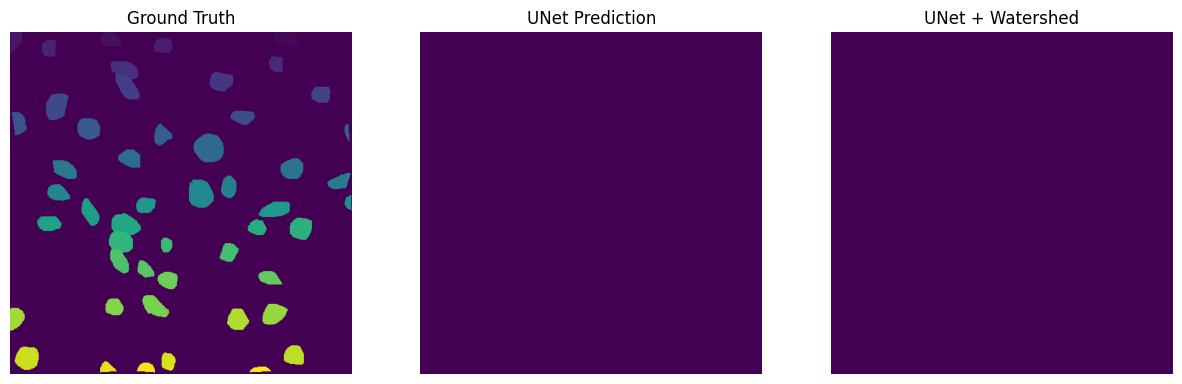

In [21]:
import matplotlib.pyplot as plt

# Pick an index of the validation image you want to visualize
idx = 0

# Ground truth mask
gt_mask = validation_set_label[idx]

# Predicted mask (raw UNet)
pred_mask = output_raw  # make sure it's the corresponding output for idx

# Predicted mask (watershed)
pred_watershed = output_watershed  # make sure it's the corresponding output for idx

# Display side by side
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(gt_mask)
axs[0].set_title('Ground Truth')
axs[0].axis('off')

axs[1].imshow(pred_mask)
axs[1].set_title('UNet Prediction')
axs[1].axis('off')

axs[2].imshow(pred_watershed)
axs[2].set_title('UNet + Watershed')
axs[2].axis('off')

plt.show()


In [26]:
from scipy.ndimage import gaussian_filter, label as ndi_label
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from skimage.morphology import remove_small_objects
from skimage.io import imsave
import numpy as np
from tqdm import tqdm

#Loading in Later
# pred_val: model_raw.predict(validation_set_img)
pred_val_seg = pred_val[0]  # segmentation output
pred_dis = pred_val[1]      # distance map output

dice_unet = np.zeros([len(pred_val_seg)])
AJI_unet = np.zeros([len(pred_val_seg)])
PQ_unet = np.zeros([len(pred_val_seg)])

dice_unet_watershed = np.zeros([len(pred_val_seg)])
AJI_unet_watershed = np.zeros([len(pred_val_seg)])
PQ_unet_watershed = np.zeros([len(pred_val_seg)])

dice_unet_watershed_without_vague = np.zeros([len(pred_val_seg)])
AJI_unet_watershed_without_vague = np.zeros([len(pred_val_seg)])
PQ_unet_watershed_without_vague = np.zeros([len(pred_val_seg)])

for val_len in tqdm(range(len(pred_val_seg))):

    # --- Threshold binary mask ---
    image = (np.squeeze(pred_val_seg[val_len]) > opts['treshold']).astype(np.uint8)

    # --- Distance map ---
    distance_map = np.squeeze(pred_dis[val_len])

    # --- Gaussian smoothing ---
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(image, connectivity=8)
    sizes = stats[1:, cv2.CC_STAT_AREA]
    sigma = 1 if len(sizes) == 0 else max(1, int(np.mean(sizes)**0.5))
    smoothed_dis = gaussian_filter(distance_map, sigma=sigma)

    # --- Local maxima for watershed ---
    coords = peak_local_max(image, footprint=np.ones((15,15)), exclude_border=False, labels=None)
    local_maxi = np.zeros_like(image, dtype=bool)
    if len(coords) > 0:
        local_maxi[tuple(coords.T)] = True
    marker = ndi_label(local_maxi)[0]

    # --- Watershed ---
    output_watershed = watershed(-smoothed_dis, marker, mask=image)
    output_watershed = remove_small_objects(output_watershed, min_size=50, connectivity=2)

    # --- Raw segmentation without watershed ---
    output_raw = skimage.morphology.label(image)
    output_raw = remove_small_objects(output_raw, min_size=50, connectivity=2)

    # --- Remap labels ---
    output_watershed = remap_label(output_watershed)
    output_raw = remap_label(output_raw)
    validation_set_label[val_len] = remap_label(validation_set_label[val_len])

    # --- Save outputs ---
    test_name = get_id_from_file_path(test_img[val_len], '.png')
    imsave(opts['result_save_path']+'validation/watershed_unet/{}.png'.format(test_name),
           output_watershed.astype(np.uint16))
    imsave(opts['result_save_path']+'validation/unet/{}.png'.format(test_name),
           output_raw.astype(np.uint16))

    # --- Metrics ---
    dice_unet[val_len] = get_dice_1(validation_set_label[val_len], output_raw)
    AJI_unet[val_len] = get_fast_aji(validation_set_label[val_len], output_raw)
    PQ_unet[val_len] = get_fast_pq(validation_set_label[val_len], output_raw)[0][2]

    dice_unet_watershed[val_len] = get_dice_1(validation_set_label[val_len], output_watershed)
    AJI_unet_watershed[val_len] = get_fast_aji(validation_set_label[val_len], output_watershed)
    PQ_unet_watershed[val_len] = get_fast_pq(validation_set_label[val_len], output_watershed)[0][2]

    # --- Watershed without vague regions ---
    output_watershed_wo_vague = np.copy(output_watershed)
    output_watershed_wo_vague[validation_set_vague[val_len]==255] = 0
    output_watershed_wo_vague = remove_small_objects(output_watershed_wo_vague, min_size=50, connectivity=2)

    validation_label_wo_vague = np.copy(validation_set_label[val_len])
    validation_label_wo_vague[validation_set_vague[val_len]==255] = 0
    validation_label_wo_vague = remove_small_objects(validation_label_wo_vague, min_size=50, connectivity=2)

    output_watershed_wo_vague = remap_label(output_watershed_wo_vague)
    validation_label_wo_vague = remap_label(validation_label_wo_vague)

    dice_unet_watershed_without_vague[val_len] = get_dice_1(validation_label_wo_vague, output_watershed_wo_vague)
    AJI_unet_watershed_without_vague[val_len] = get_fast_aji(validation_label_wo_vague, output_watershed_wo_vague)
    PQ_unet_watershed_without_vague[val_len] = get_fast_pq(validation_label_wo_vague, output_watershed_wo_vague)[0][2]

# --- Print averages ---
print('Average Dice Unet: {:.2f}'.format(np.mean(dice_unet)*100))
print('Average AJI Unet: {:.2f}'.format(np.mean(AJI_unet)*100))
print('Average PQ Unet: {:.2f}'.format(np.mean(PQ_unet)*100))

print('Average Dice Unet Watershed: {:.2f}'.format(np.mean(dice_unet_watershed)*100))
print('Average AJI Unet Watershed: {:.2f}'.format(np.mean(AJI_unet_watershed)*100))
print('Average PQ Unet Watershed: {:.2f}'.format(np.mean(PQ_unet_watershed)*100))

print('Average Dice Unet Watershed wo Vague: {:.2f}'.format(np.mean(dice_unet_watershed_without_vague)*100))
print('Average AJI Unet Watershed wo Vague: {:.2f}'.format(np.mean(AJI_unet_watershed_without_vague)*100))
print('Average PQ Unet Watershed wo Vague: {:.2f}'.format(np.mean(PQ_unet_watershed_without_vague)*100))


  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/skimage/_shared/utils.py:328: UserWarning: /content/drive/My Drive/NuInsSeg/ddunet/prediction_image/validation/watershed_unet/mouse_kidney_32.png is a low contrast image
  return func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/skimage/_shared/utils.py:328: UserWarning: /content/drive/My Drive/NuInsSeg/ddunet/prediction_image/validation/unet/mouse_kidney_32.png is a low contrast image
  return func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/skimage/_shared/utils.py:328: UserWarning: /content/drive/My Drive/NuInsSeg/ddunet/prediction_image/validation/watershed_unet/mouse_kidney_08.png is a low contrast image
  return func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/skimage/_shared/utils.py:328: UserWarning: /content/drive/My Drive/NuInsSeg/ddunet/prediction_image/validation/unet/mouse_kidney_08.png is a low contrast image
  return func(*args, **kwargs)
 10%|█         | 2

Average Dice Unet: 0.00
Average AJI Unet: 0.00
Average PQ Unet: 0.00
Average Dice Unet Watershed: 0.00
Average AJI Unet Watershed: 0.00
Average PQ Unet Watershed: 0.00
Average Dice Unet Watershed wo Vague: 0.00
Average AJI Unet Watershed wo Vague: 0.00
Average PQ Unet Watershed wo Vague: 0.00


In [27]:
pred_val = model_raw.predict(validation_set_img, verbose=1, batch_size=1)

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 363ms/step


In [36]:
print(len(pred_val[0][0]))

512


In [43]:
pred_val_seg = pred_val[0]  # semantic segmentation head
pred_val_t = (pred_val_seg > 0.0).astype(np.uint8)
print("Pred min/max:", pred_val_seg.min(), pred_val_seg.max())
print("Pred thresholded unique values:", np.unique(pred_val_t))

Pred min/max: -0.0933535 0.0767174
Pred thresholded unique values: [0 1]


In [44]:
print("Validation images shape:", validation_set_img.shape)
print("Image min/max:", validation_set_img.min(), validation_set_img.max())


Validation images shape: (20, 512, 512, 3)
Image min/max: 0.09411764705882353 0.7215686274509804


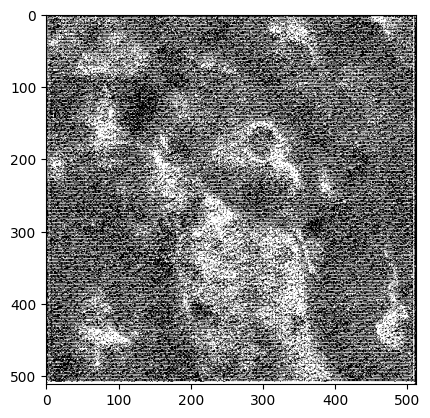

TypeError: Invalid shape (512,) for image data

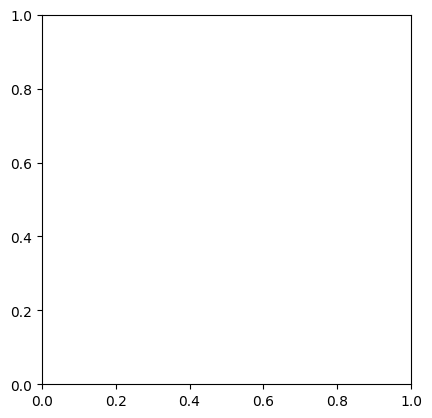

In [46]:
import matplotlib.pyplot as plt
plt.imshow(pred_val_t[0], cmap='gray')  # raw thresholded mask
plt.show()
plt.imshow(output_watershed[0], cmap='nipy_spectral')  # watershed result
plt.show()


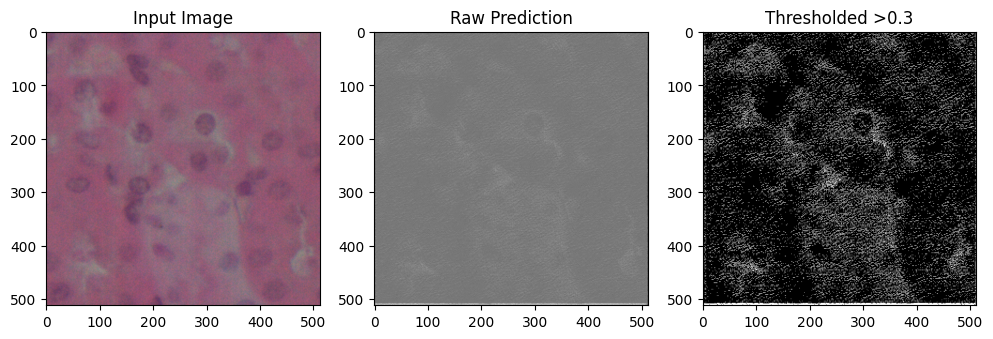

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(validation_set_img[0])
plt.title("Input Image")
plt.subplot(1,3,2)
plt.imshow(pred_val_seg[0, :, :, 0], cmap='gray')
plt.title("Raw Prediction")
plt.subplot(1,3,3)
plt.imshow((pred_val_seg[0, :, :, 0]>0.005).astype(np.uint8), cmap='gray')
plt.title("Thresholded >0.3")
plt.show()


In [55]:
from skimage.morphology import label, remove_small_objects
from skimage.segmentation import relabel_sequential
import numpy as np

# Arrays to store scores
dice_unet_raw = np.zeros(len(validation_set_img))
AJI_unet_raw = np.zeros(len(validation_set_img))
PQ_unet_raw = np.zeros(len(validation_set_img))

# Threshold for raw predictions
threshold = 0.01  # tweak if predictions are tiny

for i in range(len(validation_set_img)):
    # --- Threshold binary mask ---
    image = (np.squeeze(pred_val_seg[i]) > threshold).astype(np.uint8)

    # --- Label objects ---
    labeled_image = label(image)
    labeled_image = remove_small_objects(labeled_image, min_size=50)

    # --- Make labels consecutive to avoid IndexError ---
    labeled_image, _, _ = relabel_sequential(labeled_image)

    # --- Compute metrics ---
    dice_unet_raw[i] = get_dice_1(validation_set_label[i], labeled_image)
    AJI_unet_raw[i] = get_fast_aji(validation_set_label[i], labeled_image)
    PQ_unet_raw[i] = get_fast_pq(validation_set_label[i], labeled_image)[0][2]

# --- Print averages ---
print("Average Dice Unet (raw): {:.2f}".format(np.mean(dice_unet_raw)*100))
print("Average AJI Unet (raw): {:.2f}".format(np.mean(AJI_unet_raw)*100))
print("Average PQ Unet (raw): {:.2f}".format(np.mean(PQ_unet_raw)*100))


Average Dice Unet (raw): 0.21
Average AJI Unet (raw): 0.10
Average PQ Unet (raw): 0.00
